# ESDA with rgeoda and sf

Another modern and popular routine for spatial data analysis with R is to use [sf](https://github.com/r-spatial/sf) library to process geospatial dataset, analyze spatial data and plot the results on maps.

rgeoda provides utility functions to create a `geoda` instance from an `sf` object, so that users can easily integrate the functions of spatial data analysis in rgeoda into their existing work.

In this note, we will work with `sf` and `rgeoda` libraries to do exploratory spatial data analysis (ESDA).

## Start from sf package

The sf package has been popular tool to handle geospatial data. It is a good substitue of sp package which will be deprecated soon.

For example, to load a geospatial data (e.g. a ESRI Shapefile) using sf:

In [1]:
# use the Guerry.shp comes with the rgeoda package
guerry_path <- system.file("extdata", "Guerry.shp", package = "rgeoda")

# load sf library
library(sf)

Linking to GEOS 3.7.2, GDAL 2.4.1, PROJ 6.1.0


Note: to install sf library in R, you can run: `install.packages('sf')`


Then, we can call `st_read()` function to read Guerry.shp file and this function will returns an `sf` object


In [2]:
guerry_sf <- st_read(guerry_path)


Reading layer `Guerry' from data source `/usr/local/lib/R/3.6/site-library/rgeoda/extdata/Guerry.shp' using driver `ESRI Shapefile'
Simple feature collection with 85 features and 26 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 47680 ymin: 1703258 xmax: 1031401 ymax: 2677441
epsg (SRID):    27572
proj4string:    +proj=lcc +lat_1=46.8 +lat_0=46.8 +lon_0=0 +k_0=0.99987742 +x_0=600000 +y_0=2200000 +a=6378249.2 +b=6356515 +towgs84=-168,-60,320,0,0,0,0 +pm=paris +units=m +no_defs


You can simply call plot() function to render the first 9 chorepleth maps using the frist 9 variables in the dataset:


Warning message:
“plotting the first 9 out of 26 attributes; use max.plot = 26 to plot all”

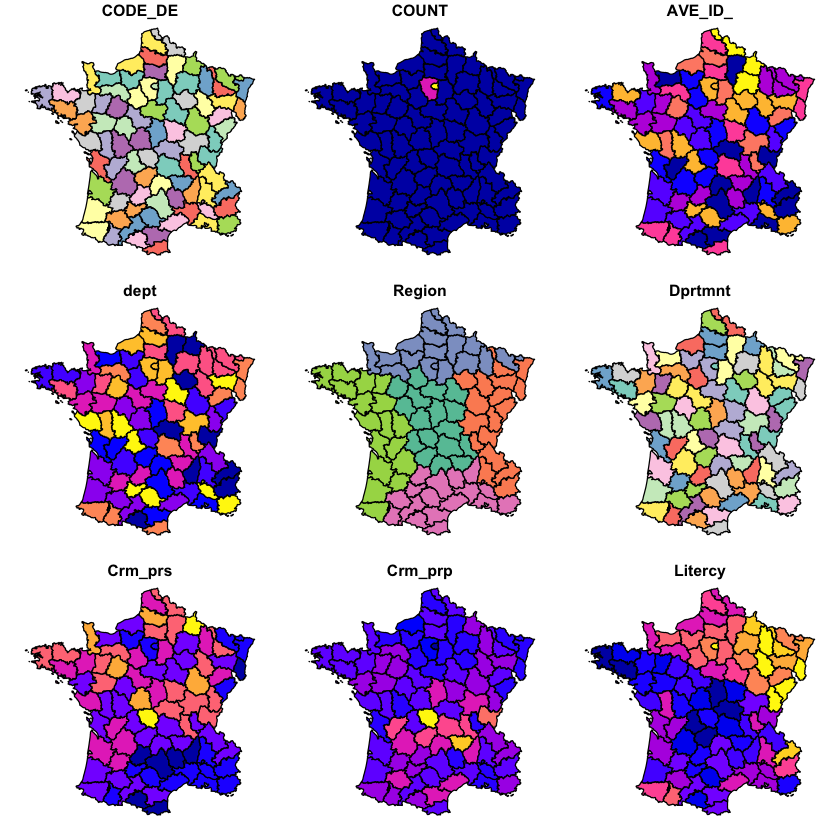

In [3]:
plot(guerry_sf)


## Create geoda object from sf

sf package makes it easy to work with geospatial data. It also provides functions to do basic spatial data analysis. rgeoda provides helper function sf_to_geoda to create a geoda object from a sf object. Users can then call rgeoda functions to do further spatial data analysis.

Create a geoda object from the sf object guerry_sp you just created.

In [4]:
# load rgeoda library
library(rgeoda)

# call function to create a geoda object from sf object
guerry <- sf_to_geoda(guerry_sf)

Loading required package: wkb


rgeoda uses wkb, which is a binary representation of geometries, to exchange data between sf and libgeoda in memory.

By default, sf_to_geoda() only using geometries to create a geoda object, which is fast and user can reuse the data.frame from the sf object to do analysis. This function has an optional parameter `with_table`, to allow user to use both geometries and data.frame to create a geoda object by calling, for example: sp_to_geoda(guerry_sp, with_table=TRUE)


## ESDA with rgeoda and sf

Now, with the geoda object `guerry`, you can call rgeoda’s spatial analysis functions. For example, to examine the local Moran statistics of variable “crm_prs” (Population per Crime against persons):


In [5]:
queen_w <- queen_weights(guerry)
crm_prp <- as.numeric(guerry_sf$Crm_prp)

```
Note: Why are we using `as.numeric(as.character(guerry_sp$Crm_prp))`?

As we can see from the output of `readOGR(guerry_path)` that: _"Integer64 fields read as strings:  dept Crm_prs Crm_prp Litercy Donatns Infants Suicids MainCty_", so `guerry_sp$Crm_prp` is with data type `factor`, so `as.numeric(as.character())` is used to convert it to a column with numeric values without lossing precisions.
```

### Local Moran Map




In [6]:
lisa <- local_moran(queen_w, crm_prp)


Now, with the LISA results, we can do exploratory spatial data analysis by generating a LISA cluster map:


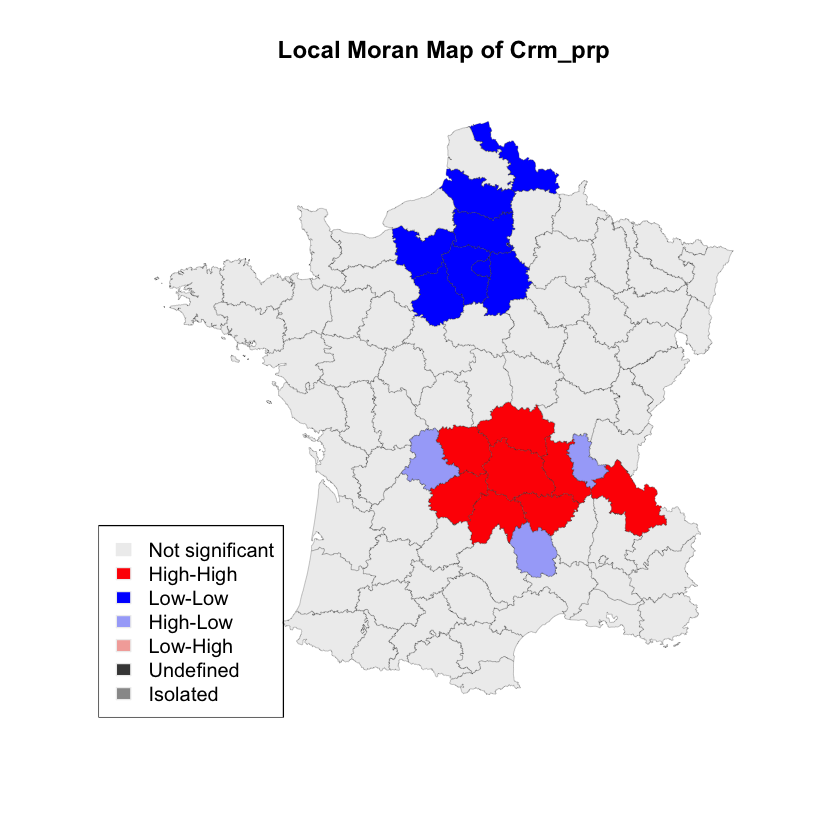

In [7]:
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(st_geometry(guerry_sf), 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

From the above code, you can see that we still use `sp` object to do plotting. The values of cluster indicators from rgeoda’s `LISA` object are used to make the LISA map.This emphasis that rgeoda is a API focused library, which only provides the core functions of spatial data analysis for easy integration.

You can easily append the lisa results to original sp object by manipulating the data.frame object inside the sp object.

In [8]:
guerry_sf$moran_cluster <- lisa_clusters

If you check the values of the cluster indicators, you will see they are integer numbers 0 (not significant), 1 (high-high cluster), 2 (low-low cluster), 3 (low-high cluster), 4 (high-low cluster), 5 (neighborless/island), 6 (undefined), which are excatly the same with GeoDa software when you save LISA results to a table:

In [9]:
lisa_clusters

[1] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 0
[39] 0 1 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 2 2 0 0 1 0 0 0 0 0 3 0 0 0 2 0 2 2 0 2
[77] 0 0 0 0 0 0 3 0 0

To create a siginificant map that is associated with the Local Moran map:


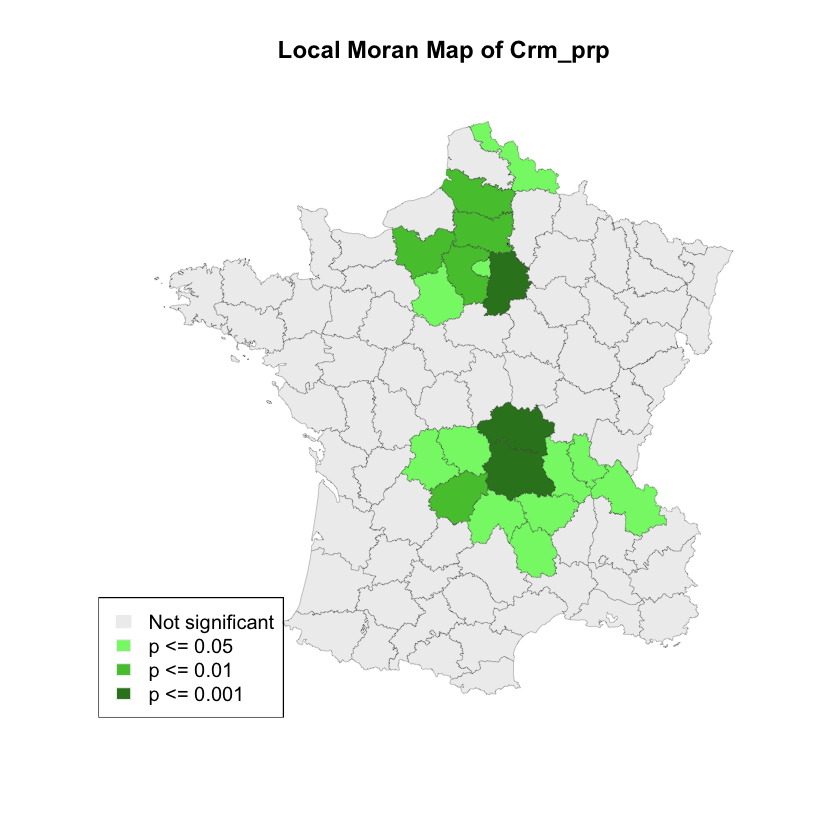

In [9]:
lisa_p <- lisa$GetPValues()
p_labels <- c("Not significant", "p <= 0.05", "p <= 0.01", "p <= 0.001")
p_colors <- c("#eeeeee", "#84f576", "#53c53c", "#348124")
plot(st_geometry(guerry_sf), 
     col=sapply(lisa_p, function(x){
       if (x <= 0.001) return(p_colors[4])
       else if (x <= 0.01) return(p_colors[3])
       else if (x <= 0.05) return (p_colors[2])
       else return(p_colors[1])
       }), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = p_labels, fill = p_colors, border = "#eeeeee")

### Local Geary Map

Another example is to create a map of local Geary:

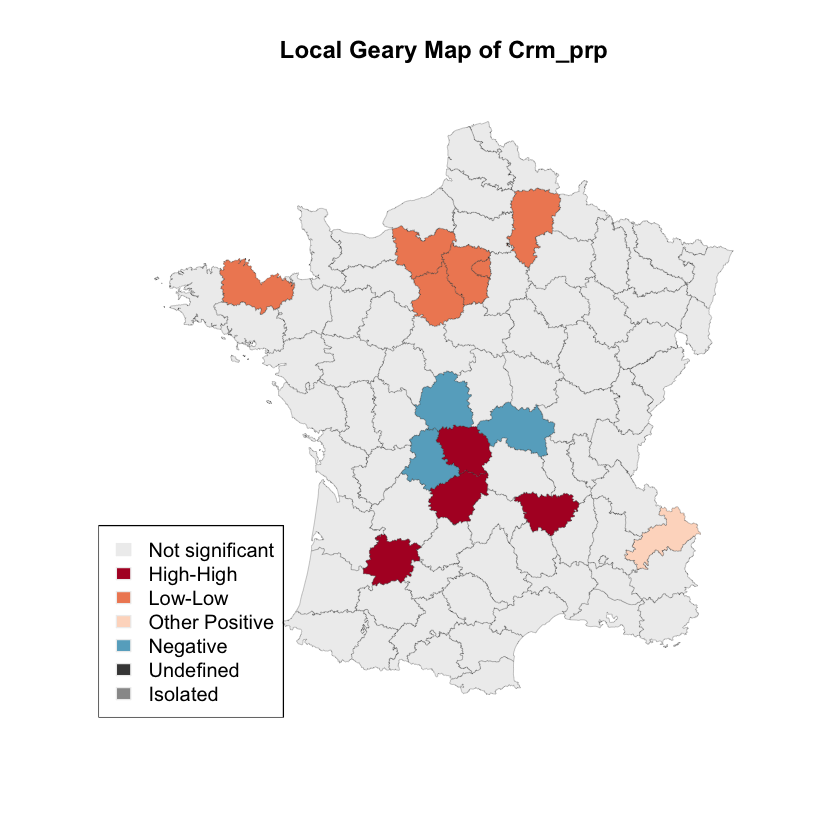

In [10]:
lisa <- local_geary(queen_w, crm_prp)
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(st_geometry(guerry_sf), 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Geary Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### Local G Map

To create a map of local G:

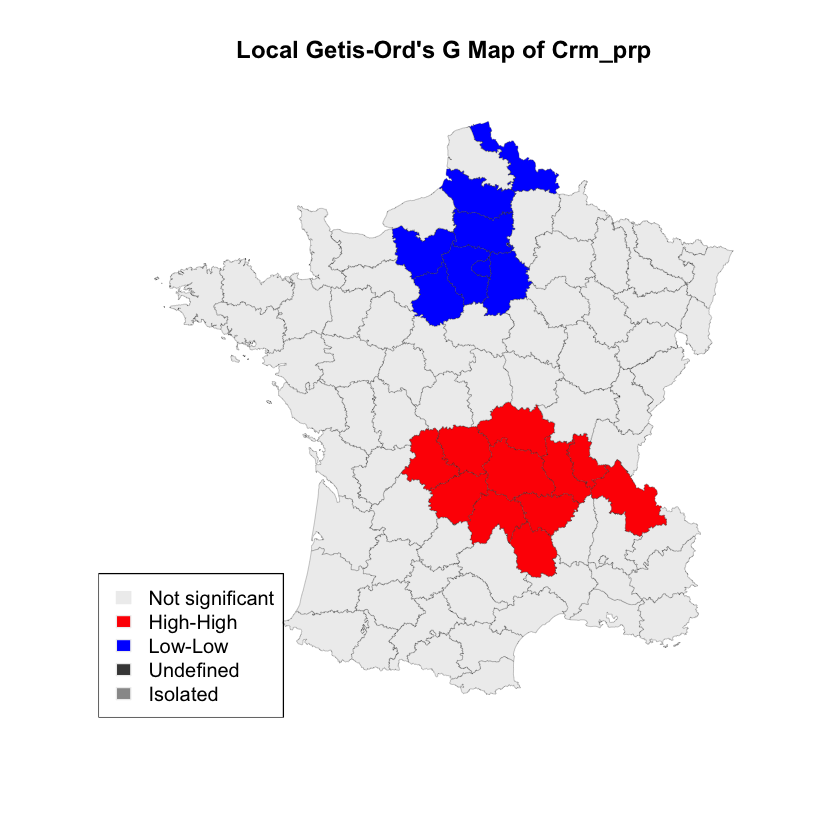

In [11]:
lisa <- local_g(queen_w, crm_prp)
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(st_geometry(guerry_sf), 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Getis-Ord's G Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### SKATER Map

To create a map of SKATER clustering map:

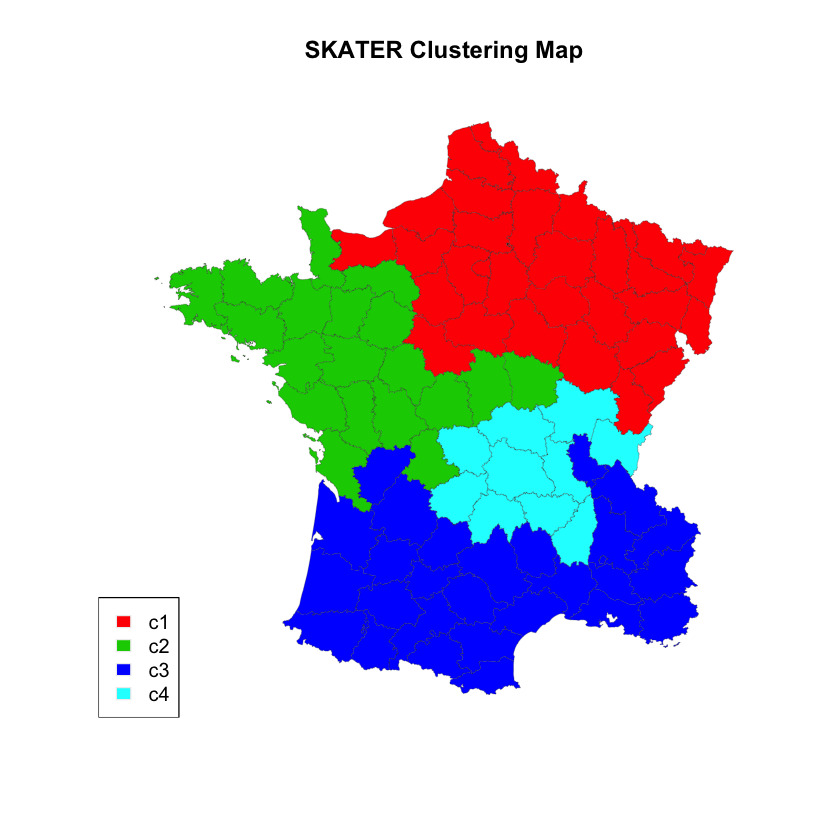

In [12]:
Crm_prp <- as.numeric(guerry_sf$Crm_prp)
Litercy <- as.numeric(guerry_sf$Litercy)
Donatns <- as.numeric(guerry_sf$Donatns)
Infants <- as.numeric(guerry_sf$Infants)
Suicids <- as.numeric(guerry_sf$Suicids)
data <- list(crm_prp, Crm_prp, Donatns, Infants, Suicids)
guerry_clusters <- skater(4, queen_w, data)

# Get some colors for each clusters
skater_colors <- palette()[2:5]
skater_labels <- c("c1","c2","c3","c4")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:4) {
  for (j in guerry_clusters[i]) {
    colors[j+1] <- skater_colors[i]
  }
}

# plot
plot(st_geometry(guerry_sf),  col=colors, border = "#333333", lwd=0.2)
title(main = "SKATER Clustering Map")
legend('bottomleft', legend = skater_labels, fill = skater_colors, border = "#eeeeee")

### Max-p Clustering Map

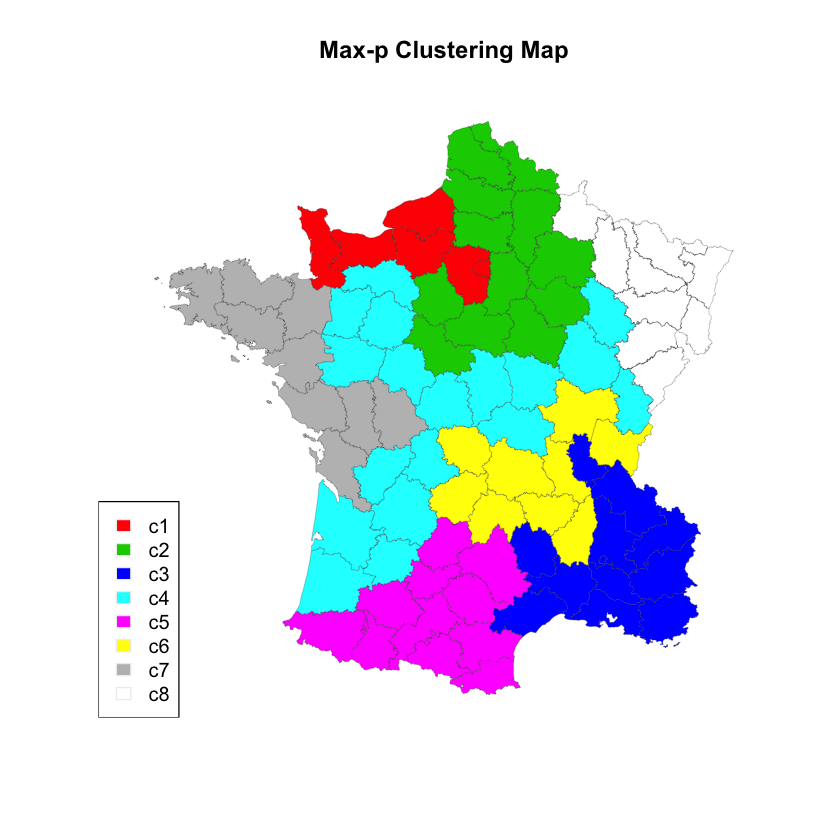

In [13]:
bound_vals <- as.numeric(guerry_sf$Pop1831)
min_bound <- 3236.67 # 10% of Pop1831

maxp_clusters <- maxp(queen_w, data, bound_vals, min_bound, "greedy")

# Get some colors for each clusters
maxp_colors <- palette()[2:10]
maxp_labels <- c("c1","c2","c3","c4","c5","c6","c7","c8")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:8) {
  for (j in maxp_clusters[i]) {
    colors[j+1] <- maxp_colors[i]
  }
}

# plot
plot(st_geometry(guerry_sf),  col=colors, border = "#333333", lwd=0.2)
title(main = "Max-p Clustering Map")
legend('bottomleft', legend = maxp_labels, fill = maxp_colors, border = "#eeeeee")